For this setup

- No feature scaling → XGBoost doesn’t need it.

- No need to drop multicollinear features → trees handle it naturally.

- No need to drop raw features used for creating PCA/clusters → trees can hande repeated signal. But should be dropped in case of linear models.

- Default hyperparameters already give strong performance.

Later we will:

- Tune max_depth, learning_rate, n_estimators.

- Use early_stopping_rounds with a validation set.

- Check feature importance with xgb.feature_importances_.

In [ ]:
# ================================================
# 1. Imports
# ================================================
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor

# ================================================
# 2. Load datasets (feature engineered, leakage-safe)
# ================================================
train_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train.csv", index_col=0)
dev_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_dev.csv", index_col=0)

# Clustering features
train_clustering_features = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_train_with_clustering.csv", index_col=0)
dev_clustering_features = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/feature_engineered_dev_with_clustering.csv", index_col=0)

features_to_use = ['cluster_dist_1', 'cluster_dist_2', 'cluster_dist_3',
       'cluster_dist_4', 'cluster_dist_5', 'cluster_dist_6', 'cluster_dist_7',
       'cluster_dist_8', 'cluster_dist_9', 'cluster_dist_10']

train_clustering_features = train_clustering_features[features_to_use]
dev_clustering_features = dev_clustering_features[features_to_use]

# PCA features
train_pca_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/train_pca_features.csv", index_col=0)
dev_pca_df = pd.read_csv("/Users/aaditya.paliwal/Desktop/regression_ml_end2end/data/processed/dev_pca_features.csv", index_col=0)

# ================================================
# 3. Define target & features
# ================================================
target = "price"
X_train = train_df.drop(columns=[target])
y_train = train_df[target]

X_dev = dev_df.drop(columns=[target])
y_dev = dev_df[target]

# ================================================
# 4. Train a simple XGBoost Regressor
# ================================================
xgb_model = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

xgb_model.fit(X_train, y_train)

# ================================================
# 5. Evaluate performance
# ================================================
y_pred = xgb_model.predict(X_dev)

mae = mean_absolute_error(y_dev, y_pred)
rmse = np.sqrt(mean_squared_error(y_dev, y_pred))
r2 = r2_score(y_dev, y_pred)

print("XGBoost Performance:")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

XGBoost Performance:
MAE: 32,774.60
RMSE: 72,137.37
R²: 0.9598


- **Adding clustering features**

In [ ]:
# Using cluster features along with raw features

X_train_with_cluster = pd.concat([X_train, train_clustering_features], axis=1)
X_dev_with_cluster = pd.concat([X_dev, dev_clustering_features], axis=1)

# Fitting the model
xgb_model.fit(X_train_with_cluster, y_train)

# Evaluating the performance
y_pred_cluster = xgb_model.predict(X_dev_with_cluster)

mae_cluster = mean_absolute_error(y_dev, y_pred_cluster)
rmse_cluster = np.sqrt(mean_squared_error(y_dev, y_pred_cluster))
r2_cluster = r2_score(y_dev, y_pred_cluster)

print("XGBoost Performance:")
print(f"MAE: {mae_cluster:,.2f}")
print(f"RMSE: {rmse_cluster:,.2f}")
print(f"R²: {r2_cluster:.4f}")

XGBoost Performance:
MAE: 32,650.77
RMSE: 71,849.14
R²: 0.9601


- **Adding PCA features**

In [6]:
# Using PCA features along with raw features

X_train_with_pca = pd.concat([X_train, train_pca_df], axis=1)
X_dev_with_pca = pd.concat([X_dev, dev_pca_df], axis=1)

# Fitting the model
xgb_model.fit(X_train_with_pca, y_train)

# Evaluating the performance
y_pred_pca = xgb_model.predict(X_dev_with_pca)

mae_pca = mean_absolute_error(y_dev, y_pred_pca)
rmse_pca = np.sqrt(mean_squared_error(y_dev, y_pred_pca))
r2_pca = r2_score(y_dev, y_pred_pca)

print("XGBoost Performance:")
print(f"MAE: {mae_pca:,.2f}")
print(f"RMSE: {rmse_pca:,.2f}")
print(f"R²: {r2_pca:.4f}")

XGBoost Performance:
MAE: 32,696.17
RMSE: 71,547.00
R²: 0.9604


- **Adding both clustering & PCA features**

In [ ]:
# Using Clustering + PCA features along with raw features

X_train_full = pd.concat([X_train, train_clustering_features, train_pca_df], axis=1)
X_dev_full = pd.concat([X_dev, dev_clustering_features, dev_pca_df], axis=1)

# Fitting the model
xgb_model.fit(X_train_full, y_train)

# Evaluating the performance
y_pred_full = xgb_model.predict(X_dev_full)

mae_full = mean_absolute_error(y_dev, y_pred_full)
rmse_full = np.sqrt(mean_squared_error(y_dev, y_pred_full))
r2_full = r2_score(y_dev, y_pred_full)

print("XGBoost Performance:")
print(f"MAE: {mae_full:,.2f}")
print(f"RMSE: {rmse_full:,.2f}")
print(f"R²: {r2_full:.4f}")

XGBoost Performance:
MAE: 32,864.80
RMSE: 72,524.11
R²: 0.9593


- **Using clustering + pca features** but taking only those raw features not used for PCA, since PCA is linear rotation of the original space. Whereas clustering highlights a non-linear interaction, hence we can keep the raw features used for clustering.

In [26]:
features_used_for_clustering = ['bank', 'bus', 'hospital', 'mall', 'park',
       'restaurant', 'school', 'station', 'supermarket', 'Total Population',
       'Median Age', 'Per Capita Income', 'Total Families Below Poverty',
       'Total Housing Units', 'Median Rent', 'Median Home Value', 'Median Commute Time']

features_used_for_pca = ['homes_sold', 'pending_sales', 'new_listings',
       'inventory', 'median_dom', 'avg_sale_to_list', 'sold_above_list',
       'off_market_in_two_weeks'] + ['median_list_price', 'median_ppsf',
       'median_list_ppsf', 'Median Home Value', 'Median Rent'] + ['Total Population', 'Median Age', 'Per Capita Income', 'Total Families Below Poverty',
                         'Total Labor Force', 'Unemployed Population', 'Total School Enrollment', 'Median Commute Time']

all_columns = X_train.columns

features_to_keep = list(set(all_columns)-set(features_used_for_pca) | set(features_used_for_clustering))

In [ ]:
X_train_full_selected_raw = pd.concat([X_train[features_to_keep], train_clustering_features, train_pca_df], axis=1)
X_dev_full_selected_raw = pd.concat([X_dev[features_to_keep], dev_clustering_features, dev_pca_df], axis=1)

# Fitting the model
xgb_model.fit(X_train_full_selected_raw, y_train)

# Evaluating the performance
y_pred_full_selected_raw = xgb_model.predict(X_dev_full_selected_raw)

mae_full_selected_raw = mean_absolute_error(y_dev, y_pred_full_selected_raw)
rmse_full_selected_raw = np.sqrt(mean_squared_error(y_dev, y_pred_full_selected_raw))
r2_full_selected_raw = r2_score(y_dev, y_pred_full_selected_raw)

print("XGBoost Performance:")
print(f"MAE: {mae_full_selected_raw:,.2f}")
print(f"RMSE: {rmse_full_selected_raw:,.2f}")
print(f"R²: {r2_full_selected_raw:.4f}")

# The performance actually fell as the raw features were actually carrying the important signal and helping the model perform better

XGBoost Performance:
MAE: 37,205.28
RMSE: 80,730.53
R²: 0.9496


Hence, we can conclude with our set of experiments that:
- Adding only Clustering features helped in getting the best model performance. 
- However, the performance uplift is very marginal.  
  
Hence, we can totally let go of the clustering features and can directly work with our engineered features.

XGBoost Performance:
MAE: 32,774.60
RMSE: 72,137.37
R²: 0.9598


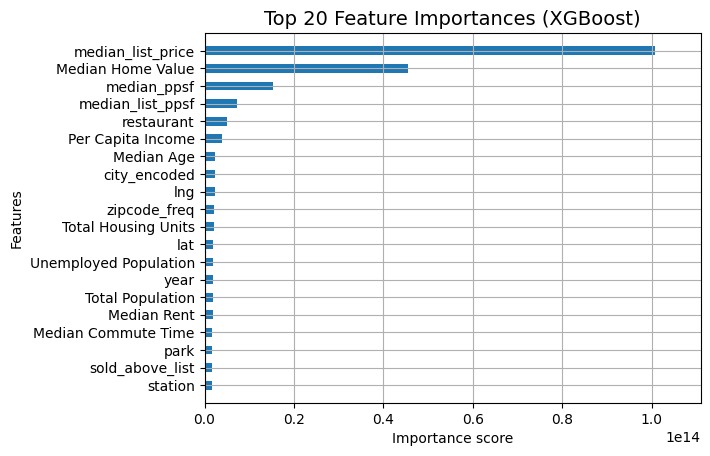

In [30]:
# Plot importances
import matplotlib.pyplot as plt
from xgboost import plot_importance

# Fitting the model on original set of features

xgb_model.fit(X_train, y_train)
y_pred = xgb_model.predict(X_dev)

mae = mean_absolute_error(y_dev, y_pred)
rmse = np.sqrt(mean_squared_error(y_dev, y_pred))
r2 = r2_score(y_dev, y_pred)

print("XGBoost Performance:")
print(f"MAE: {mae:,.2f}")
print(f"RMSE: {rmse:,.2f}")
print(f"R²: {r2:.4f}")

plot_importance(
    xgb_model,
    importance_type="gain",
    max_num_features=20,
    height=0.5,
    show_values=False
)
plt.title("Top 20 Feature Importances (XGBoost)", fontsize=14)
plt.show()